In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Convert to all numerical

In [242]:
df = data.copy()
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [21]:
df['MSSubClass'].isnull().sum()

0

In [9]:
df['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [14]:
MSSubClass = pd.get_dummies(df['MSSubClass']).drop(40,axis=1)

In [20]:
df['MSZoning'].isnull().sum()

0

In [15]:
df['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [16]:
MSZoning = pd.get_dummies(df['MSZoning']).drop('C (all)',axis=1)

In [22]:
df['Alley'].isnull().sum()

1369

In [18]:
df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [23]:
Alley = pd.get_dummies(df['Alley'])

In [40]:
def make_dummy(df, column):
    """
    Take a column name and make a dummy DataFrame from it
        If there are Null values, do not omit one (null will be the 0's)
        otherwise, remove the one will the least counts,
        return the dataFrame
    """
    nulls = df[column].isnull().sum()
    rarest = df[column].value_counts().index[-1]
    dummies = pd.get_dummies(df[column])
    if (nulls>0):
        return dummies
    else:
        return dummies.drop(rarest,axis=1)

### Only linear features for now:

In [83]:
X_df = data[['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','TotalBsmtSF',
             '1stFlrSF','2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF',
             'OpenPorchSF','ScreenPorch']]
X_df = X_df.fillna(0)
y_df = data['SalePrice']

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [85]:
tree = RandomForestRegressor(100)
reg = LinearRegression()

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

In [87]:
tree.fit(X_train,y_train)
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [88]:
tree.score(X_test,y_test),reg.score(X_test,y_test)

(0.8377110049164064, 0.7597915135161433)

In [89]:
tree.feature_importances_

array([0.01864863, 0.02612781, 0.02292419, 0.069138  , 0.15173962,
       0.03817401, 0.05379409, 0.3781492 , 0.18579879, 0.0137881 ,
       0.03369917, 0.0080184 ])

In [90]:
reg.coef_

array([ 2.38969496,  0.15371644, 44.11256088, 10.26847453, 38.41381599,
       59.48734058, 69.93481433, -8.56745229, 91.8201022 , 54.11460183,
       42.09850775, 52.94771328])

In [94]:
features = pd.DataFrame([tree.feature_importances_,reg.coef_],columns=X_df.columns).transpose()
features.columns = ['Tree','Regression']

In [99]:
features.sort_values('Tree',ascending=False)

,Tree,Regression
GrLivArea,0.378149,-8.567452
GarageArea,0.185799,91.820102
TotalBsmtSF,0.151740,38.413816
BsmtFinSF1,0.069138,10.268475
2ndFlrSF,0.053794,69.934814
1stFlrSF,0.038174,59.487341
OpenPorchSF,0.033699,42.098508
LotArea,0.026128,0.153716
MasVnrArea,0.022924,44.112561
LotFrontage,0.018649,2.389695


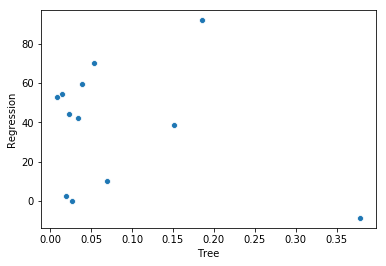

In [100]:
sns.scatterplot(features['Tree'],features['Regression'])

### Feature testing class

I will construct a feature testing class that will help me manage this task more easily

In [252]:
"""
Feature Tester
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

class FeatureTester():
        
    def __init__(self, data, test_size=0.2, random_seed='random', cv=5, precision=4):
        """
        Initialize the feature tester, provide data as a pandas dataframe, including the y column
        """
        self.data = data
        # features to use, and type of feature
        self.features = []
        # features not to use
        self.dont_use = []
        # list of estimators and their names
        self.estimators = []
        self.names = []
        # random seem to train_test_split
        if (random_seed=='random'):
            self.random_seed = np.random.randint(0,1000)
        # test size (in train_test_split)
        self.test_size = test_size
        # number of CV iterations
        self.cv = cv
        # number of decimal points to show
        self.precision = precision
        
    def set_y(self,column):
        """Mark the y column (by name)"""
        self.y = column
    
    def add_feature(self,feature,dtype='numerical',arg='auto'):
        """
        Add feature to the regression
            default is numerical
            
            ordinal can be specified in dtype, if so, a conversion dictionary might be required
            
            categorical can be specified in dtype, if so, feature will be converted to dummy columns
                by default omitting NaN or the least frequest label
                (otherwise, dummy to omit can be specified by name)
        """
        if (dtype=='numerical'):
            # add as is
            self.features.append((feature,dtype))
        elif(dtype=='ordinal'):
            # add converted with optional dictionary
            self.features.append((feature,dtype,arg))
        elif(dtype=='categorical'):
            # add converted to dummies
            self.features.append((feature,dtype,arg))  
    
    def print_features(self,type_filter=None,return_tuple=False):
        """Return list of features in a concise representation"""
        if (type_filter) == None:
            return [feature[0] for feature in self.features]
        elif (return_tuple):
            return [feature for feature in self.features if feature[1]==type_filter]
        else:
            return [feature[0] for feature in self.features if feature[1]==type_filter]
    
    def find_feature_index(self,feature):
        """Find the index of a feature by name"""
        i = 0
        for f in self.features:
            if (f[0] == feature):
                break
            i+=1
        return i

    def modify_feature(self,feature,dtype,arg=None):
        """Modify a feature and score it"""
        i = self.find_feature_index(feature)
        if (arg is None):
            self.features[i] = (feature,dtype)
        else:
            self.features[i] = (feature,dtype,arg)
        return self.score_feature(feature)
    
    def remove_feature(self,feature):
        """Move the last added feature(s) to the No pile
        """
        i = self.find_feature_index(feature)
        removed = self.features.pop(i)
        self.dont_use.append(removed[0])
        # run fit again to correct self.previous
        self.fit()
    
    def add_estimator(self,estimator,name):
        """Add a named estimator to perform regression with"""
        self.estimators.append(estimator)
        self.names.append(name)
    
    def fit(self,compare=False,skip=None):
        """
        Fit the selected features and return scores
            compare will also print the different in the score from the previous fit
            skip allows user to skip a single feature (for recomparing etc)
        """
        X, y = self.build_data(skip)
        # fit and score
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=self.test_size, random_state=self.random_seed)
        scores = []
        for estimator in self.estimators:
            scores.append( cross_val_score(estimator,X_train,y_train,cv=5).mean() )
        if (compare):
            diff = np.asarray(scores) - np.asarray(self.previous)
            self.previous = scores
            scores_diff = np.round(np.concatenate((scores,diff)),self.precision)
            return np.concatenate((self.names,scores_diff)).reshape(3,len(scores)).T
        self.previous = scores
        return np.concatenate((self.names,np.round(scores,self.precision))).reshape(2,len(scores)).T
    
    def score_feature(self,feature):
        """Check the difference is scoring with and without a feature"""
        self.fit(skip=feature)
        return self.fit(True)
    
    def sanity_check(self):
        """Make sure there is nothing that makes not sense or that raises red flags"""
        features = self.print_features()
        duplicates = set([f for f in features if features.count(f) > 1])
        if (len(duplicates)>0):
            print('Warning, you have duplicates')
            print(duplicates)
        yes_and_no = set([f for f in features if f in self.dont_use])
        if (len(yes_and_no)>0):
            print('Warning, you have features both in use and in dont_use')
            print(yes_and_no)
        missing_features = []
        for f in self.data.columns:
            if (f not in features and f not in self.dont_use):
                missing_features.append(f)
        if (len(missing_features)>0):
            print('Note, there are features in the dataset that were not tested')
            print(missing_features)
        
    def build_data(self,skip=None):
        # add numerical features
        numerical = self.print_features('numerical')
        if (skip in numerical):
            numerical.remove(skip)
        X = data[numerical]
        # add ordinal features
        ordinal = self.print_features('ordinal',True)
        for feature in ordinal:
            if (feature[0]!=skip):
                if (feature[2] == 'auto'):
                    X = np.hstack((X,self.data[feature[0]][:,None]))
                else:
                    column = self.data[feature[0]].map(feature[2])
                    X = np.hstack((X,column[:,None]))
        # add categorical features
        categorical = self.print_features('categorical',True)
        for feature in categorical:
            if (feature[0]!=skip):
                if (feature[2]=='auto'):
                    dummies = make_dummy(data,feature[0])
                else:
                    dummies = make_dummy(data,feature[0],feature[2])
                X = np.hstack((X,dummies))
        # y 
        y = data[self.y]
        return X, y 

def get_dict(df,column):
    """
    Return an empty dictionary for user to fill
        this should make ordinal and categorical binning easier
    """
    return dict([(f,0) for f in df[column].unique()])

def observe_feature(df,column,y):
    n = df[column].nunique()
    if (n>=20):
        sns.scatterplot(x=column,y=y,data=df)
    if (n<20):
        print(data[column].value_counts())
        sns.boxplot(x=column,y=y,data=data.fillna('nan'))
        plt.show()
            
def make_dummy(df, column,omit=None):
    """
    Take a column name and make a dummy DataFrame from it
        If there are Null values, do not omit one (null will be the 0's)
        otherwise, remove the one will the least counts,
        return the dataFrame
            optional - omit the specified label
    """
    nulls = df[column].isnull().sum()
    rarest = df[column].value_counts().index[-1]
    dummies = pd.get_dummies(df[column])
    if (nulls>0):
        if (omit is not None):
            raise ValueError('NaN values are present, omit cannot be specified')
        return dummies
    elif (omit is None):
        return dummies.drop(rarest,axis=1)
    else:
        return dummmies.drop(omit,axis=1)

In [253]:
ft = FeatureTester(data)
ft.set_y('SalePrice')
ft.add_feature('LotArea')
ft.add_estimator(LinearRegression(),'Linear')
#ft.add_estimator(RandomForestRegressor(50),'Forest')
print(ft.fit())
ft.add_feature('GrLivArea')
print(ft.fit(True))

[['Linear' '0.0495']]
[['Linear' '0.4954' '0.4459']]


In [237]:
ft.add_feature('LotShape','ordinal',{'Reg':1,'IR1':2,'IR2':3,'IR3':3})

In [238]:
ft.modify_feature('LotShape','ordinal',{'Reg':0,'IR1':2,'IR2':4,'IR3':3})

array([['Linear', '0.4914', '0.0207']], dtype='<U32')

In [239]:
ft.add_feature('OverallQual','ordinal')
ft.fit(True)

array([['Linear', '0.671', '0.1795']], dtype='<U32')

In [240]:
ft.add_feature('MSZoning','categorical')
ft.fit(True)

array([['Linear', '0.6895', '0.0186']], dtype='<U32')

In [241]:
ft.add_feature('PoolArea','ordinal',{0: 0, 512: 1, 648: 1, 576: 1, 555: 1, 480: 1, 519: 1, 738: 1})
ft.fit(True)

array([['Linear', '0.6646', '-0.0249']], dtype='<U32')

In [246]:
ft.score_feature('PoolArea')

array([['Linear', '0.6646', '-0.0249']], dtype='<U32')

In [224]:
ft.modify_feature('PoolArea','numerical')

array([['Linear', '0.7054', '-0.01']], dtype='<U32')

In [247]:
ft.random_seed

96

In [243]:
X,y = ft.build_data()

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.2, random_state=96)

In [250]:
cross_val_score(ft.estimators[0],X_train,y_train,cv=5).mean()

0.6646220742827585

In [251]:
cross_val_score(ft.estimators[0],np.delete(X_train,4,axis=1),y_train,cv=5).mean()

0.6895398478290574

In [197]:
ft.features

[('LotArea', 'numerical'),
 ('GrLivArea', 'numerical'),
 ('LotShape', 'ordinal', {'Reg': 0, 'IR1': 2, 'IR2': 4, 'IR3': 3}),
 ('OverallQual', 'ordinal', 'auto'),
 ('MSZoning', 'categorical', 'auto'),
 ('PoolArea',
  'ordinal',
  {0: 0, 512: 1, 648: 1, 576: 1, 555: 1, 480: 1, 519: 1, 738: 1})]

In [208]:
np.delete(X,4,axis=1)

array([[ 8450,  1710,     0, ...,     0,     1,     0],
       [ 9600,  1262,     0, ...,     0,     1,     0],
       [11250,  1786,     2, ...,     0,     1,     0],
       ...,
       [ 9042,  2340,     0, ...,     0,     1,     0],
       [ 9717,  1078,     0, ...,     0,     1,     0],
       [ 9937,  1256,     0, ...,     0,     1,     0]])

In [235]:
X[:,3].sum()

1162

In [196]:
data['PoolArea'].value_counts()

0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

In [570]:
a = make_dummy(data,'PoolArea')[data['PoolArea']>0]

In [167]:
get_dict(data,'PoolArea')`

{0: 0, 512: 0, 648: 0, 576: 0, 555: 0, 480: 0, 519: 0, 738: 0}

In [580]:
a['c'] = a.iloc[:,1:].sum(axis=1)

In [583]:
data['Id']=1298

In [584]:
data.head(1300).tail(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1295,1298,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,11,2006,WD,Normal,138500
1296,1298,20,RL,80.0,8700,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2008,WD,Normal,155000
1297,1298,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,New,Partial,140000
1298,1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1299,1298,20,RL,75.0,7500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,5,2010,WD,Normal,154000


In [162]:
a = data['PoolArea'].unique()

In [165]:
dict([(b,b) for b in a])

{0: 0, 512: 512, 648: 648, 576: 576, 555: 555, 480: 480, 519: 519, 738: 738}